In [1]:
import pandas as pd, numpy as np, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px, pickle, plotly.graph_objects as go, itertools
from tqdm import tqdm
from matplotlib.pyplot import *
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
import kneed
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report,precision_recall_fscore_support, normalized_mutual_info_score,confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, ward,single,complete
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier,StackingClassifier
from pandas.api.types import is_numeric_dtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
out_dir = Path('output')
res_dir = Path('results')
data_dir = Path('Data')
save = True
train_model = False
STATE = 1
cluster_anl = False
train_agg = True
agg_out_dir = Path('agg_output')

In [3]:
metadata = pd.read_csv(Path(data_dir,'train_data.csv'),header=None,names=['class','filename'])
metadata[['make','model','year']] = metadata['class'].str.split('_',expand=True)
features = pd.read_csv(Path(data_dir,'train_features.csv'),header=None)

In [4]:
def PCA_parameter_search(normalizers, data, func=PCA(), plotting=False, out_dir=res_dir, save=False):
    res = []
    for key in normalizers.keys():
        transformed = normalizers[key].fit_transform(data)
        func.fit(transformed)
        xs = np.arange(func.explained_variance_.shape[0])
        variance_agg = func.explained_variance_ratio_.cumsum()
        interval_95 = np.argwhere(variance_agg>.95)[0][0]
        interval_elbow = kneed.KneeLocator(xs,variance_agg,curve='concave',direction='increasing').elbow
        res.append([key, interval_95,interval_elbow])
        if plotting:
            fig = plot(xs,variance_agg, label='Aggregate PCA Variance')
            axvline(x=[interval_elbow],color='r',ls='--',label=f'Elbow Point={interval_elbow}')
            axvline(x=[interval_95],color='r',ls='--',label=f'95 Variance={interval_95}')
            xlabel('Number Components')
            ylabel('variance_ratio')
            title(f'{key}-scaled PCA')
            tight_layout()
            legend()
            if save:
                savefig(Path(out_dir,f'{key}_PCA_choice.png'))
            show()
    res = pd.DataFrame(columns = ['method','95_interval','elbow'], data=res)
    if save:
        res.to_csv(Path(out_dir,'Normalize_PCA_choices.csv'),index=False)
    return res

def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res,item='score'):
    res[f'mean_{item}'] = res[[f'mean_train_{item}',f'mean_test_{item}']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res[f'std_{item}'] = res[[f'std_train_{item}',f'std_test_{item}']].values.tolist()
    res = res.explode([f'mean_{item}','type',f'std_{item}'],ignore_index=True)
    return res



In [5]:
normalizers = {'Standard':StandardScaler(), 'MinMax':MinMaxScaler()}
# data = features.values
# key, norm = 'Standard', normalizers['Standard']
# func = PCA()

In [6]:
# pca_cutoffs = PCA_parameter_search(normalizers,features.values,plotting=True,out_dir=res_dir, save=save)
# pca_cutoffs

In [7]:
# Adjust these values for experiments of different sizes.
train_percentage = .8
dataset_percentage=1

x_train, x_test, y_train, y_test =  train_test_split(features.values,metadata['class'].values,train_size=train_percentage*dataset_percentage, test_size=(1-train_percentage)*dataset_percentage)
# else:
#     x_train = features.values
#     y_train = metadata['class'].values
#'roc_weighted':roc_auc_score(average='weighted'),
scoring_items = ['accuracy','f1_weighted','roc_auc_ovr']#{'accuracy':accuracy_score,'roc_macro':roc_auc_score,'f1_weighted':f1_score(average='weighted')}
n_transform = [250,300,400]

In [8]:
if train_model:
    #See if I can get tqdm working for this.
    svm_grids = {
            #'clf__kernel':['rbf','sigmoid'],
            'clf__gamma':np.linspace(0,.6,15)[1:],
            'clf__C':np.linspace(.25,1.25,10),
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
            'pca':[PCA(n_components=.95),None]
            #'scaler':list(normalizers.values()),
            #'pca__n_components':[.9, .95,.99]
        }
    #, max_iter=500
    svm_pipe = Pipeline([('Kmean',KMeans()),('pca',PCA(n_components = .95)),('scaler',MinMaxScaler()),('clf',SVC(kernel='rbf',probability=True))])
    svm_cv = GridSearchCV(svm_pipe, svm_grids, n_jobs=-1, verbose=10, cv=4, return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    svm_cv.fit(x_train, y_train)
    with open(Path(out_dir, 'svm_cv.pkl'),'wb') as fil:
        pickle.dump(svm_cv,fil)
    del svm_cv
    del svm_pipe
    






In [9]:
if train_model:
    mlp_grid = {
            'clf__hidden_layer_sizes' : [[128,128,64,64],[256,128,256,128,64],[256,128,64,64]],
            'clf__alpha': np.linspace(.2,.4,6),
            'clf__learning_rate_init':np.linspace(0,.02,6)[1:],
            'pca':[PCA(n_components=.95),None],
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None]
            #'scaler':list(normalizers.values()),
            #'pca__n_components':np.linspace(.9,.99,11)
        }
    mlp_pipe = Pipeline([('Kmean',KMeans()),('pca',PCA(n_components=.9)),('scaler',MinMaxScaler()),('clf',MLPClassifier())])
    mlp_cv = GridSearchCV(mlp_pipe, mlp_grid, n_jobs=-1, verbose=10, cv=4, return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    mlp_cv.fit(x_train, y_train)
    with open(Path(out_dir, 'mlp_cv.pkl'),'wb') as fil:
        pickle.dump(mlp_cv,fil)
    del mlp_cv
    del mlp_pipe

In [10]:
if train_model:
    # alphas = np.linspace(0.01, 5, 100) # Set to be more later tonight (was 51)
    nb_grid = {'scaler':list(normalizers.values())+[None],
            #'pca__n_components':np.linspace(.5,.99,50),
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
            'pca':[PCA(.95),None]
            }
    nb_pipe = Pipeline([('Kmean',KMeans()),  ('pca',PCA()),('scaler',MinMaxScaler()),('clf',GaussianNB())])
    nb_cv = GridSearchCV(nb_pipe, nb_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    nb_cv.fit(x_train,y_train)
    if save:
        with open(Path(out_dir,'nb_cv.pkl'),'wb') as fil:
            pickle.dump(nb_cv, fil)
    del(nb_cv)
    del(nb_pipe)

In [11]:
if train_model:
    estimators = np.arange(100, 500, 50) # Originally 100, 1000, 100
    max_depth = list(range(50,300, 50)) 
    #max_depth.append(None)
    max_features = ['sqrt','log2']
    rf_grid = { #'scaler':list(normalizers.values())+['passthrough'],
            #'pca__n_components':np.linspace(.85,.95,11),
            'clf__n_estimators':estimators, 'clf__max_depth':max_depth,# 'clf__max_features':max_features
            'pca':[PCA(n_components=.9),None],
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None]
        }
    rf_pipe = Pipeline([('Kmean',KMeans()), ('pca',PCA()), ('clf',RandomForestClassifier(max_features='sqrt'))])
    rf_cv = GridSearchCV(rf_pipe, rf_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    rf_cv.fit(x_train,y_train)
    if save:
        with open(Path(out_dir,'rf_cv.pkl'),'wb') as fil:
            pickle.dump(rf_cv, fil)
    del(rf_cv)
    del(rf_pipe)

In [12]:
if train_agg:
    #models = [load_model(key, loc=out_dir).best_estimator_.named_steps['clf'] for key in ['nb','mlp','svm','rf']]
    mlp_choice = load_model('mlp', loc=out_dir).best_estimator_.named_steps['clf']
    bag_grid = {
        'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
        # 'clf__n_estimators':[16,32,64],
        # 'clf__max_samples': [.7,.8,.9,1],
        # 'clf__max_features':[.7,.8,.9,1],
        'clf__bootstrap': [True, False],
        'clf__bootstrap_features':[True,False]
    }

    bag_pipe = Pipeline([('Kmean',KMeans()),('scaler',MinMaxScaler()), ('clf',BaggingClassifier(n_estimators = 16, max_samples = .75, max_features = .75, base_estimator = mlp_choice, n_jobs=-1,random_state=STATE))])
    bag_cv = GridSearchCV(bag_pipe,bag_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'mlpbag_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_pipe)

In [13]:
if train_agg:
    NB_choice = load_model('nb', loc=out_dir).best_estimator_.named_steps['clf']
    bag_grid = {
        'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
        'clf__n_estimators':[16,32,64,128],
        'clf__max_samples': [.7,.8,.9,1],
        'clf__max_features':[.7,.8,.9,1],
        'clf__bootstrap': [True, False],
        'clf__bootstrap_features':[True,False]
    }

    bag_pipe = Pipeline([('Kmean',KMeans()), ('scaler',MinMaxScaler()), ('clf',BaggingClassifier(n_estimators = 16, max_samples = .75, max_features = .75, base_estimator = NB_choice, n_jobs=-1,random_state=STATE))])
    bag_cv = GridSearchCV(bag_pipe,bag_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'NBbag_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_pipe)

In [11]:
if train_agg:
    svm_choice = load_model('svm', loc=out_dir).best_estimator_.named_steps['clf']
    bag_grid = {
        #'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
        'clf__max_samples': [.7,.8,.9],
        'clf__max_features':[.7,.8,.9],
        'clf__bootstrap': [True, False]
    }

    bag_pipe = Pipeline([('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()), ('clf',BaggingClassifier(n_estimators = 16, max_samples = .75, max_features = .75, base_estimator = svm_choice, n_jobs=-1,random_state=STATE))])
    bag_cv = GridSearchCV(bag_pipe,bag_grid,n_jobs=8,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'SVMbag_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_pipe)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.7
[CV 3/4; 1/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.7
[CV 4/4; 1/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.7
[CV 2/4; 1/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.7
[CV 1/4; 2/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.8
[CV 3/4; 2/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.8
[CV 2/4; 2/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.8
[CV 4/4; 2/18] START clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.8
[CV 1/4; 1/18] END clf__bootstrap=True, clf__max_features=0.7, clf__max_samples=0.7; accuracy: (train=0.984, test=0.766) f1_weighted: (train=0.984, test=0.769) roc_auc_ovr: (train=1.000, test=0.963) total time=  42.4s
[CV 1/4; 3/18] START clf__bootstr

In [14]:
if train_agg:
    bag_grid = {
        'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
        'clf__n_estimators':[16,32,64,128],
        'clf__learning_rate':[.25,.5,1,1.5]
    }

    bag_pipe = Pipeline([('Kmean',KMeans()), ('scaler',MinMaxScaler()), ('clf',AdaBoostClassifier(base_estimator = GaussianNB(),random_state=STATE))])
    bag_cv = GridSearchCV(bag_pipe,bag_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'NB_ada_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_pipe)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV 1/4; 1/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=16
[CV 2/4; 1/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=16
[CV 3/4; 1/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=16
[CV 4/4; 1/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=16
[CV 1/4; 2/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=32
[CV 4/4; 2/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=32
[CV 3/4; 2/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=32
[CV 1/4; 3/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=64
[CV 2/4; 2/64] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=32
[CV 2/4; 3/64] START Kmean=KMeans(n_clusters=250), clf__learning_

In [15]:
if train_agg:
    bag_grid = {
        'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
        'clf__n_estimators':[1000,2000,3000],
        'clf__learning_rate':[.25,.5,1,1.5]
    }
    tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)
    bag_pipe = Pipeline([('Kmean',KMeans()), ('scaler',MinMaxScaler()), ('clf',AdaBoostClassifier(n_estimators = 16, base_estimator = tree,random_state=STATE))])
    bag_cv = GridSearchCV(bag_pipe,bag_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'tree_ada_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_pipe)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV 1/4; 1/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=1000
[CV 2/4; 1/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=1000
[CV 3/4; 1/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=1000
[CV 4/4; 1/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=1000
[CV 1/4; 2/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=2000
[CV 2/4; 2/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=2000
[CV 3/4; 2/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=2000
[CV 4/4; 2/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=2000
[CV 1/4; 3/48] START Kmean=KMeans(n_clusters=250), clf__learning_rate=0.25, clf__n_estimators=3000
[CV 4/4; 3/48] START Kmean=KMeans(n_clusters=25

In [132]:
sources = ['mlp','svm','rf']
best_models = []
for source in sources:
    model_res = load_model(source)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    scores = pd.unique(df.filter(regex='train_').columns.str.split('train_').str[1])
    for score in scores:
        df = df[~df[f'mean_train_{score}'].isna()]
        df = df[~df[f'mean_test_{score}'].isna()]
    best_models.append((source,model_res.best_estimator_))

In [138]:
kmean_estimators = []
pca_estimators = []
#prefit_estimators = []
for model in best_models:
    kmean_estimators.append((f'Kmean_{model[0]}',Pipeline([('Kmean',KMeans(n_clusters=400)),('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',model[1].named_steps['clf'])])))
    pca_estimators.append((f'plain_{model[0]}',Pipeline([('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',model[1].named_steps['clf'])])))
#   prefit_estimators.append(model)
base_estimators = kmean_estimators + pca_estimators
estimators = [ [base_estimators[j] for j in i] for i in itertools.combinations(list(range(len(base_estimators))),4)]
estimators = estimators + [base_estimators,kmean_estimators,pca_estimators]

[('mlp',
  Pipeline(steps=[('Kmean', None), ('pca', None), ('scaler', MinMaxScaler()),
                  ('clf',
                   MLPClassifier(alpha=0.4, hidden_layer_sizes=[256, 128, 64, 64],
                                 learning_rate_init=0.004))])),
 ('svm',
  Pipeline(steps=[('Kmean', None), ('pca', None), ('scaler', MinMaxScaler()),
                  ('clf',
                   SVC(C=1.25, gamma=0.12857142857142856, probability=True))])),
 ('rf',
  Pipeline(steps=[('Kmean', None), ('pca', None),
                  ('clf',
                   RandomForestClassifier(max_depth=100, n_estimators=450))]))]

In [141]:
# if train_agg:
#     stack_grid = {
#         'final_estimator':[LogisticRegression(),CalibratedClassifierCV()]
#     }
#     stack_model = StackingClassifier(estimators = prefit_estimators,cv='prefit')
#     bag_cv = GridSearchCV(stack_model,stack_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
#     bag_cv.fit(x_train,y_train)
#     if save:
#         with open(Path(agg_out_dir,'stacking_cv.pkl'),'wb') as fil:
#             pickle.dump(bag_cv, fil)
#     del(bag_cv)
#     del(stack_grid)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START final_estimator=LogisticRegression()........................
[CV 2/4; 1/2] START final_estimator=LogisticRegression()........................
[CV 3/4; 1/2] START final_estimator=LogisticRegression()........................
[CV 4/4; 1/2] START final_estimator=LogisticRegression()........................
[CV 1/4; 2/2] START final_estimator=CalibratedClassifierCV()....................
[CV 2/4; 2/2] START final_estimator=CalibratedClassifierCV()....................
[CV 3/4; 2/2] START final_estimator=CalibratedClassifierCV()....................
[CV 4/4; 2/2] START final_estimator=CalibratedClassifierCV()....................
[CV 1/4; 1/2] END final_estimator=LogisticRegression(); accuracy: (train=nan, test=nan) f1_weighted: (train=nan, test=nan) roc_auc_ovr: (train=nan, test=nan) total time=   0.0s
[CV 2/4; 1/2] END final_estimator=LogisticRegression(); accuracy: (train=nan, test=nan) f1_weighted: (train=nan, tes

ValueError: 
All the 8 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py", line 584, in fit
    return super().fit(X, self._le.transform(y), sample_weight)
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py", line 183, in fit
    check_is_fitted(estimator)
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1345, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [135]:
if train_agg:
    stack_grid = {
        'final_estimator':[LogisticRegression(),CalibratedClassifierCV()],
        'estimators':estimators
    }
    stack_model = StackingClassifier(estimators = estimators,cv=4)
    bag_cv = GridSearchCV(stack_model,stack_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr')#,error_score=-1)
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'stacking_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(stack_grid)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START estimators=('prefit_mlp', ('mlp', Pipeline(steps=[('Kmean', None), ('pca', None), ('scaler', MinMaxScaler()),
                ('clf',
                 MLPClassifier(alpha=0.4, hidden_layer_sizes=[256, 128, 64, 64],
                               learning_rate_init=0.004))]))), final_estimator=LogisticRegression()
[CV 1/4; 1/6] END estimators=('prefit_mlp', ('mlp', Pipeline(steps=[('Kmean', None), ('pca', None), ('scaler', MinMaxScaler()),
                ('clf',
                 MLPClassifier(alpha=0.4, hidden_layer_sizes=[256, 128, 64, 64],
                               learning_rate_init=0.004))]))), final_estimator=LogisticRegression(); accuracy: (train=nan, test=nan) f1_weighted: (train=nan, test=nan) roc_auc_ovr: (train=nan, test=nan) total time=   0.0s
[CV 2/4; 1/6] START estimators=('prefit_mlp', ('mlp', Pipeline(steps=[('Kmean', None), ('pca', None), ('scaler', MinMaxScaler()),
                ('cl

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py", line 584, in fit
    return super().fit(X, self._le.transform(y), sample_weight)
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py", line 174, in fit
    names, all_estimators = self._validate_estimators()
  File "/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/ensemble/_base.py", line 277, in _validate_estimators
    raise ValueError(
ValueError: The estimator str should be a classifier.


In [17]:

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model', y='score'):
    test = seaborn_friendly(res,item=y)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        try:
            ax = sns.lineplot(x=x, y=f'mean_{y}',hue=param,style='type',data=test.astype({param:str}))
        except:
            if isinstance(test[x].iloc[0], KMeans):
                bootleg = []
                for item in test[x]:
                    if item is not None:
                        bootleg.append(item.n_clusters)
                    else:
                        bootleg.append('No Clustering')
                item_name = 'N Clusters'
            else:
                bootleg = []
                for item in test[x]:
                    bootleg.append(str(item))
                    item_name = 'final_estimator'
            test[item_name] = bootleg 
            hold = test[param].copy()
            test[param] = hold.astype(str) + ' Train'
            ax = sns.barplot(x=item_name, y=f'mean_{y}',hue=param,data=test.loc[test.type =='train'].astype({param:str,item_name:str}))#,order=pd.unique(test[x]),hue_order=pd.unique(test[param]))
            test[param] = hold.astype(str) + ' Test'
            sns.barplot(x=item_name, y=f'mean_{y}',hue=param,data=test.loc[test.type =='test'].astype({param:str,item_name:str}),palette='pastel')#,order=pd.unique(test[x]),hue_order=pd.unique(test[param]))
            test[param] = hold
        ax.set(title="{} {} by {}".format(key.upper(),y,param))
        if save:
            ax.get_figure().savefig(Path(out_dir,f"{param}_{y}_{x}.png"))
        show()


def analyze(key, x, test_x, test_y, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    scores = pd.unique(df.filter(regex='train_').columns.str.split('train_').str[1])
    for score in scores:
        df = df[~df[f'mean_train_{score}'].isna()]
        df = df[~df[f'mean_test_{score}'].isna()]
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    # if 'rf' in key:
    #     #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
    #     mask = df['param_max_depth'].isna()
    #     df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    if 'param_clf__hidden_layer_sizes' in  df.columns:
        df['param_clf__hidden_layer_sizes'] = df['param_clf__hidden_layer_sizes'].astype(str)
    ys = df.filter(regex='param').columns
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
        combos = [i for i in x if i != 'param_Kmean']
        for subset in itertools.combinations(combos,2):
            for score in scores:
                contour_continuous(df,subset[0],subset[1],score, key, save=save, out_dir=model_res_dir)
    print(ys)
    ys = ys.drop(droppables)
    for param in ys:
        for y in scores:
            plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key, y=y)
        #plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='fit_time')
    best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir,loc=loc)
    return df, best_res
    
def contour_continuous(df, x, y, score, item, save = False, out_dir='.'):
    title = f"{item} {score}: {x[6:]} vs. {y[6:]}"
    fig = go.Figure(data=go.Heatmap(z=df[f'mean_test_{score}'],x=df[x],y = df[y]))
    fig.data[0].update(zmin=0,zmax=1)
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y)
    if save:
        heatmap_dir = Path(out_dir,'heatmaps')
        heatmap_dir.mkdir(exist_ok=True)
        plotly.offline.plot(fig, filename=str(Path(heatmap_dir,f'{x}_{y}_{score}.html')),auto_open=False,image='png',image_filename=str(Path(heatmap_dir,f'{x}_{y}_{score}')))
    fig.show()

def handle_best(key, x_test, y_test, save=False, out_dir = out_dir,loc=out_dir):
    res = load_model(key,loc=loc)
    best_model = res.best_estimator_    
    df =  pd.DataFrame.from_dict(res.cv_results_)
    best_res = df.iloc[res.best_index_]
    le = LabelEncoder()
    le.fit(y_test)
    y_pred = best_model.predict_proba(x_test)
    best_res['best_final_test_accuracy'] = accuracy_score(le.transform(y_test),y_pred.argmax(axis=1))
    best_res['best_final_test_roc_ovr'] = roc_auc_score(pd.get_dummies(y_test),y_pred, multi_class='ovr')
    best_res['best_final_test_f1_weighted'] = f1_score(le.transform(y_test),y_pred.argmax(axis=1), average='weighted')

    best_res = best_res[best_res.index.drop(list(df.filter(regex='split')))]
    if save:
        print(out_dir)
        best_res.to_csv(Path(out_dir,'{}_best_results.csv'.format(key)))
        best_res.to_latex(Path(out_dir,'{}_best_results.tex'.format(key)))
    return best_res

def wrap_up(res_dir):
    df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()
    df.rename(index={df.index[0]:'Index'},inplace=True)
    df.drop('params',inplace=True)
    df.to_csv(Path(res_dir,'all_best.csv'),float_format='%.4f')
    df.to_latex(Path(res_dir,'all_best.tex'),float_format='%.4f')

Index(['param_clf__bootstrap', 'param_clf__max_features',
       'param_clf__max_samples', 'params'],
      dtype='object')


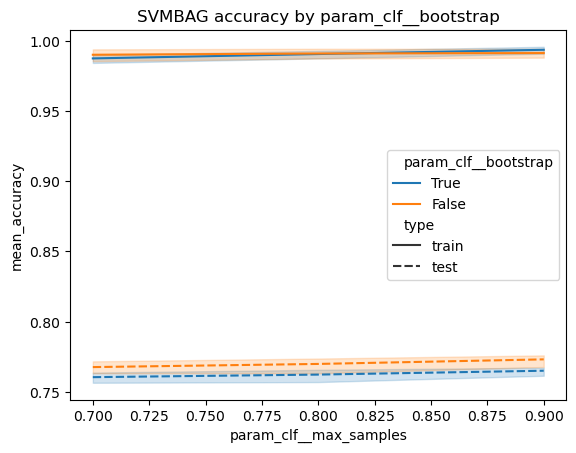

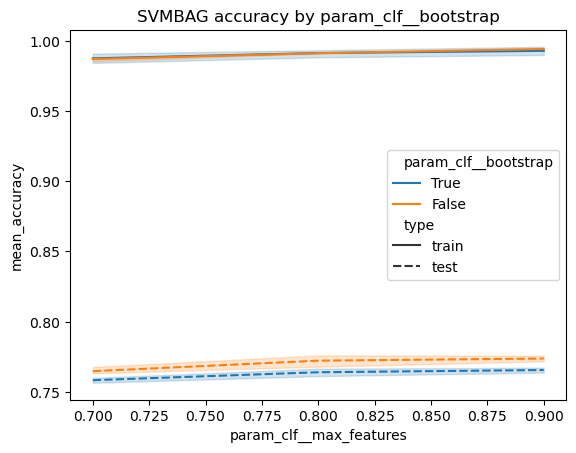

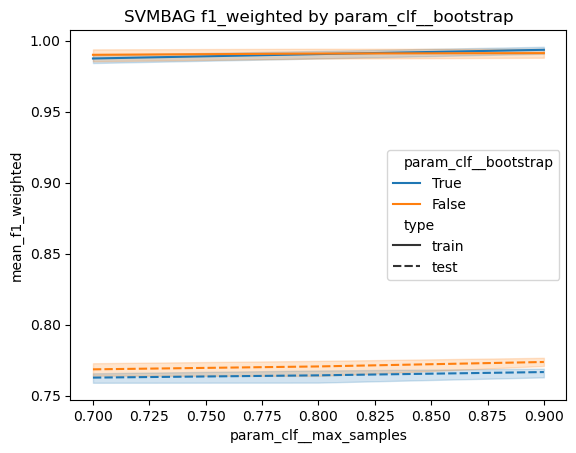

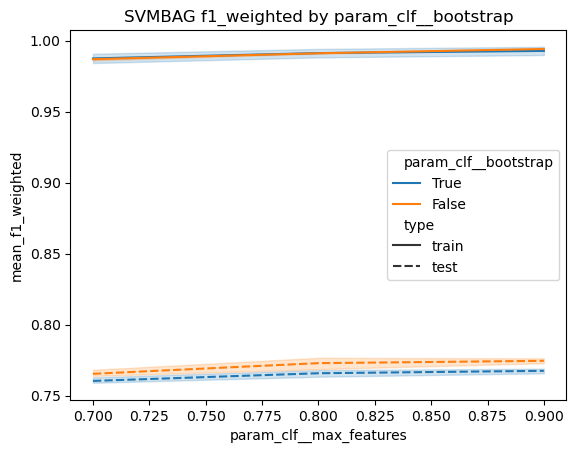

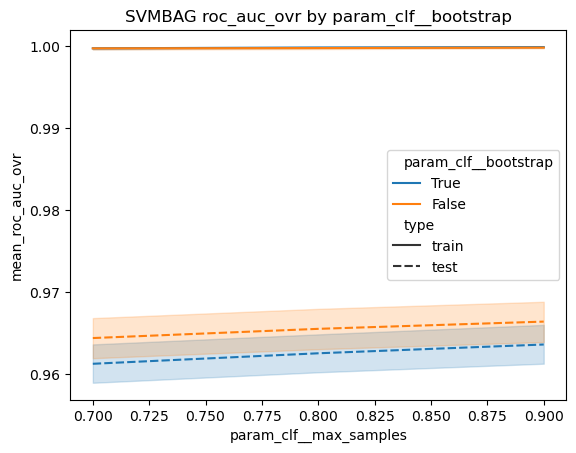

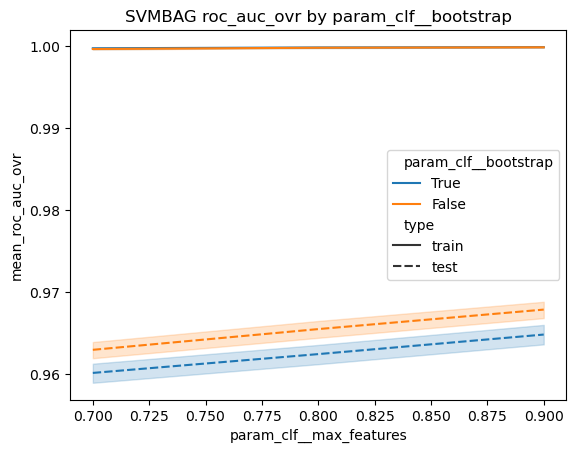

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

results/SVMbag
Index(['param_estimators', 'param_final_estimator', 'params'], dtype='object')


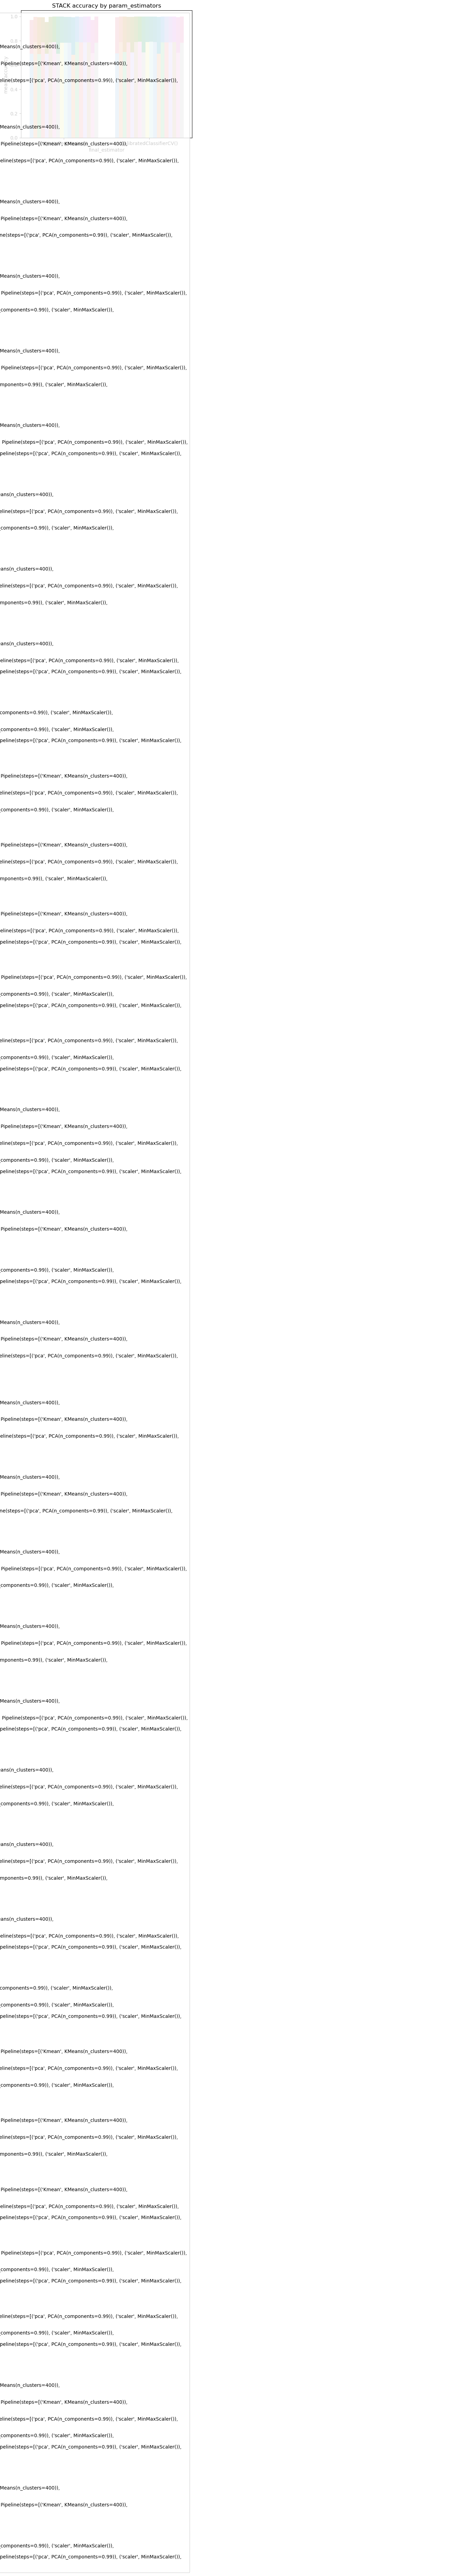

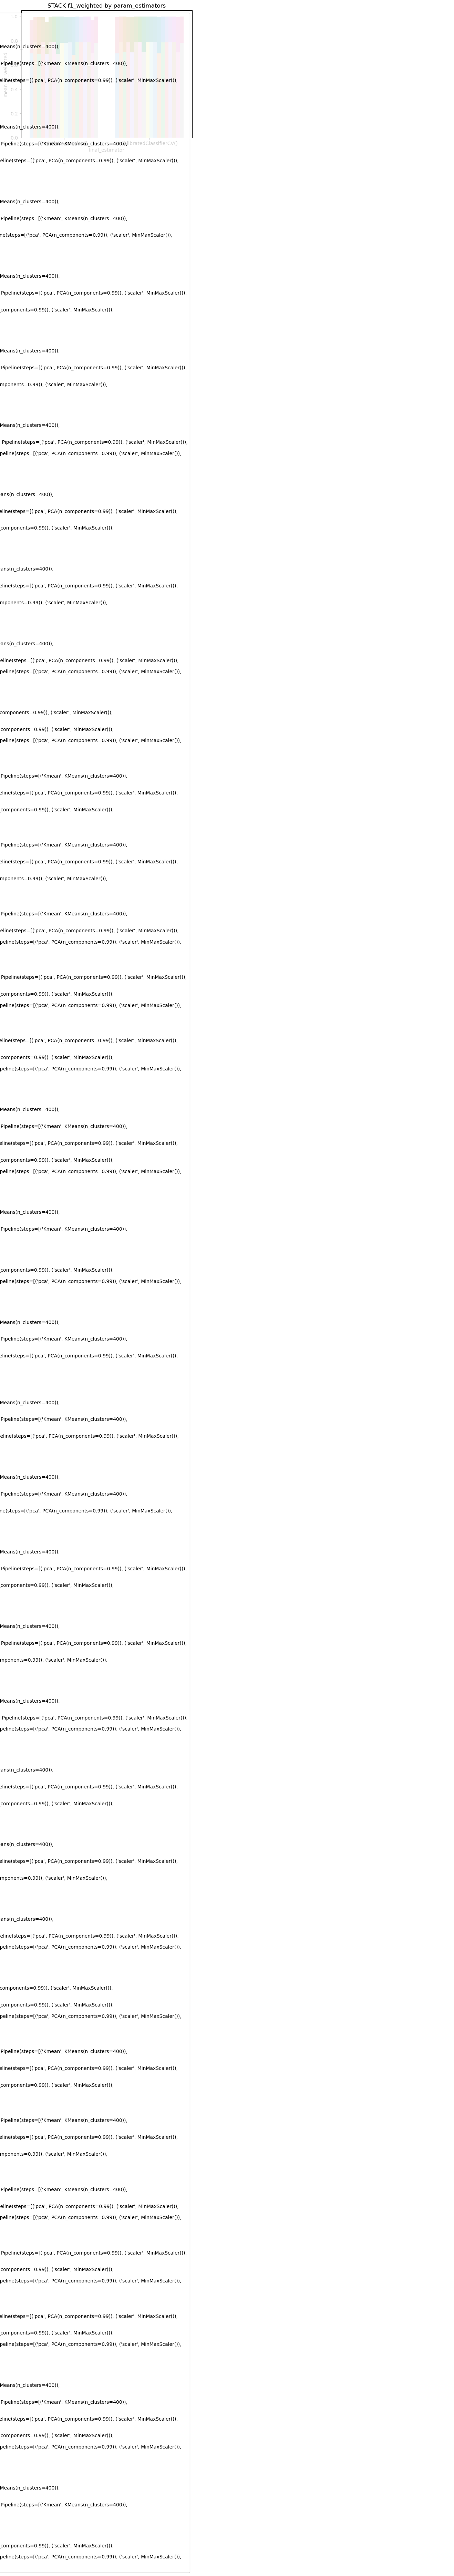

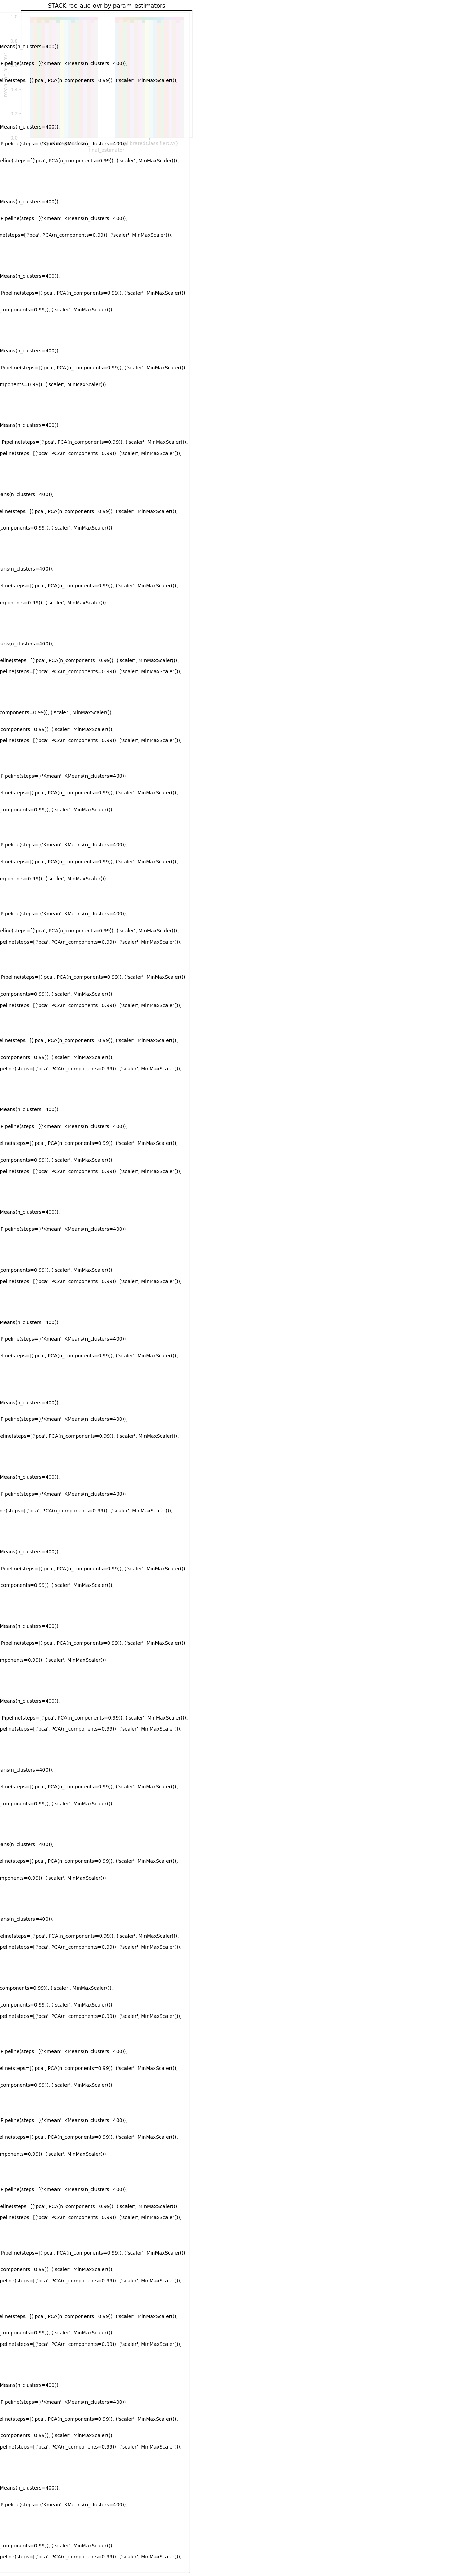

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

results/stack
Index(['param_Kmean', 'param_clf__bootstrap', 'param_clf__bootstrap_features',
       'params'],
      dtype='object')


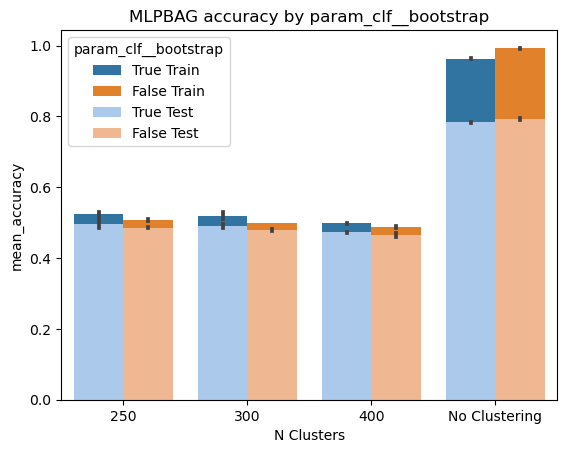

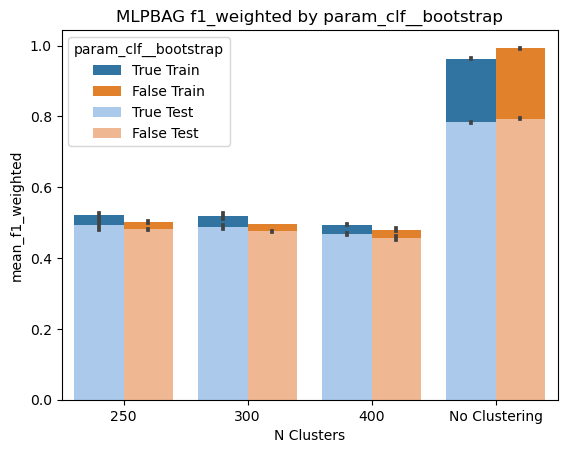

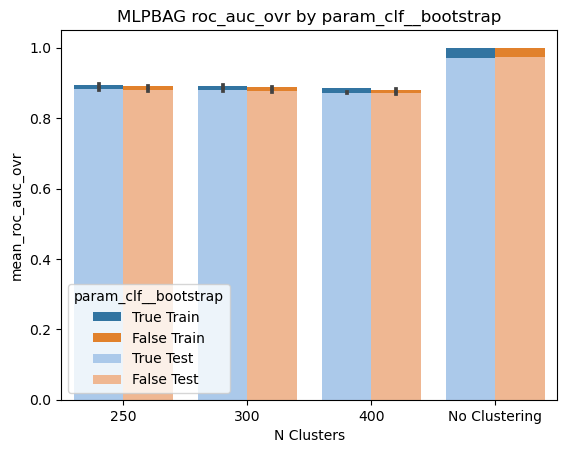

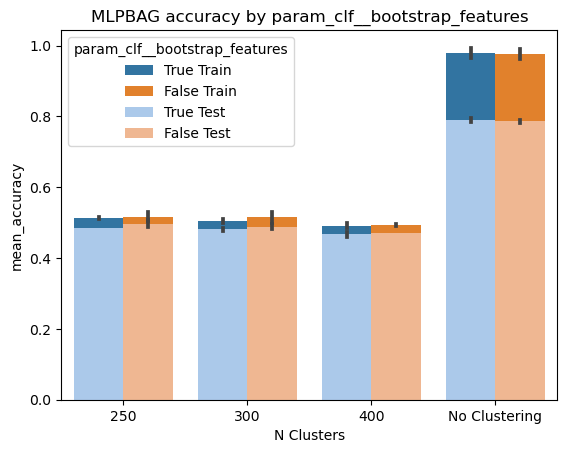

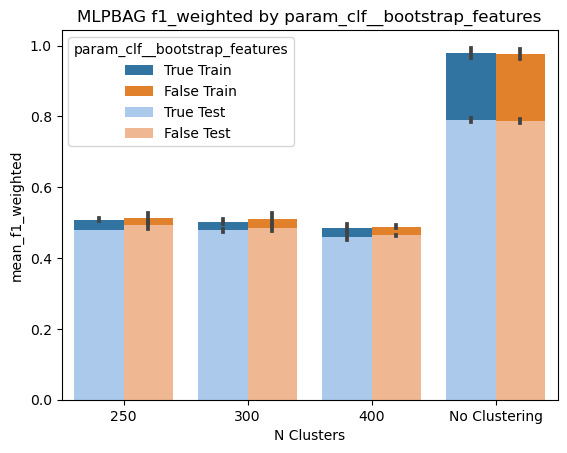

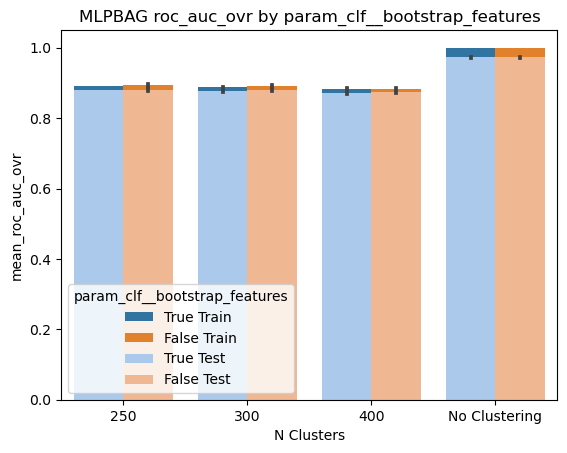

results/mlpbag


/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__bootstrap', 'param_clf__bootstrap_features',
       'param_clf__max_features', 'param_clf__max_samples',
       'param_clf__n_estimators', 'params'],
      dtype='object')


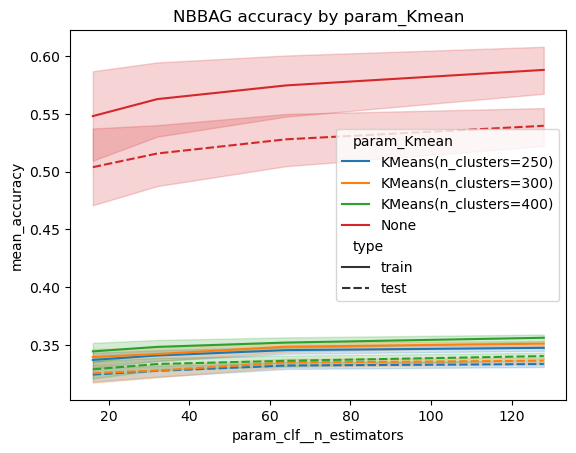

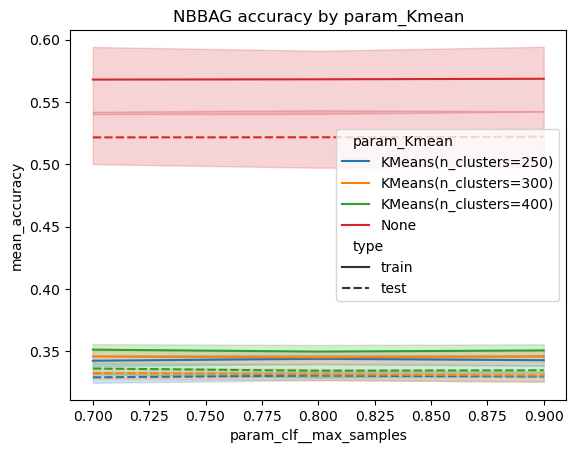

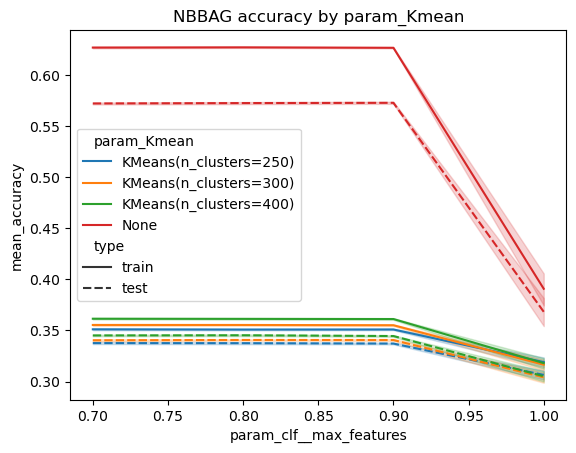

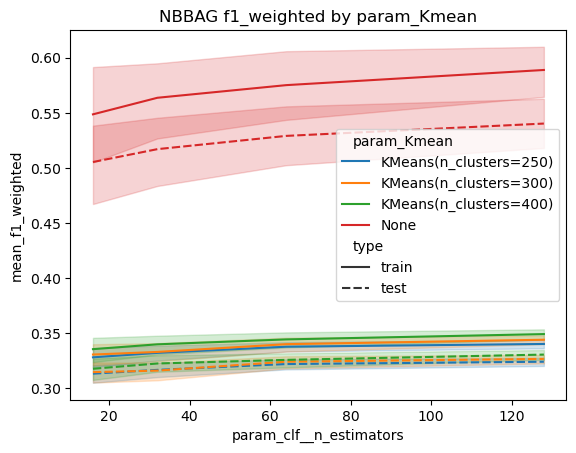

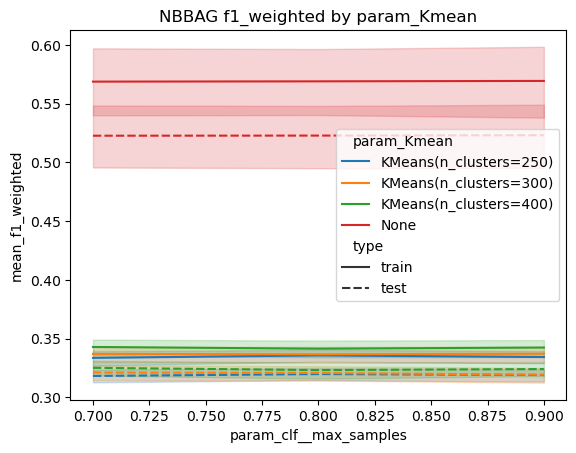

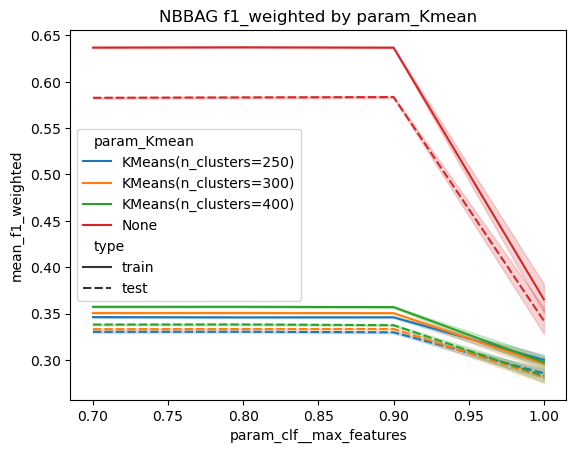

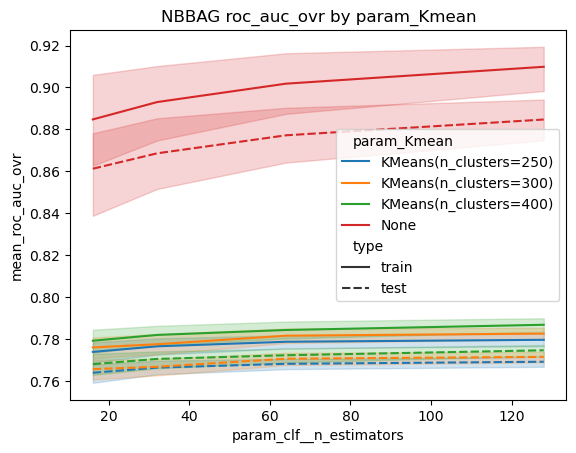

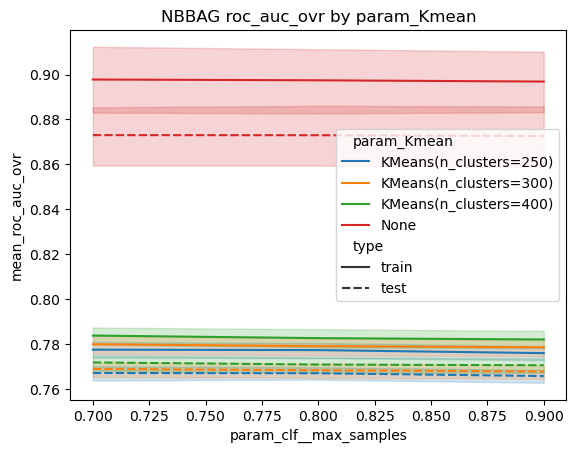

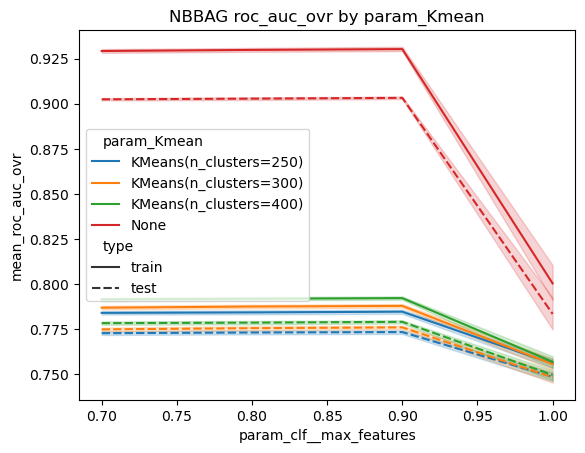

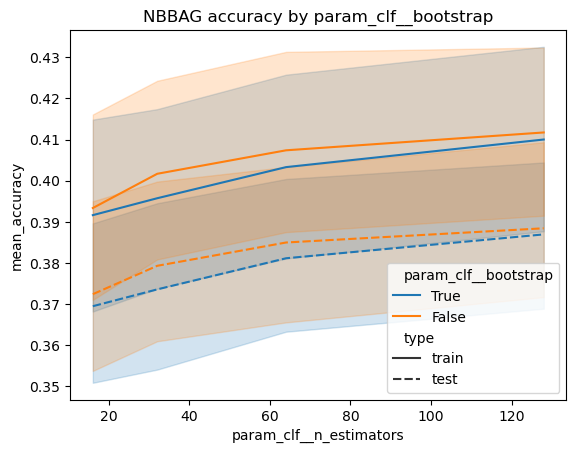

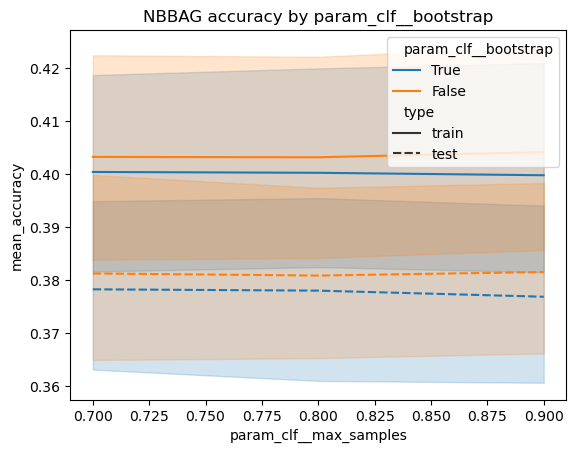

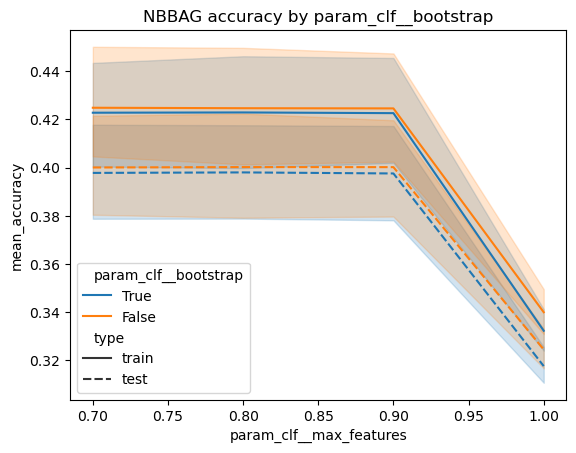

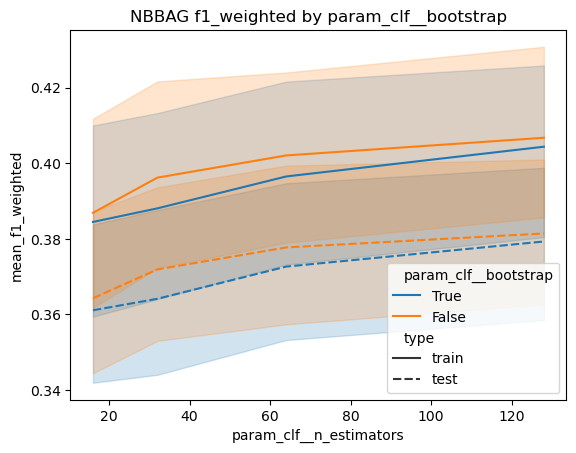

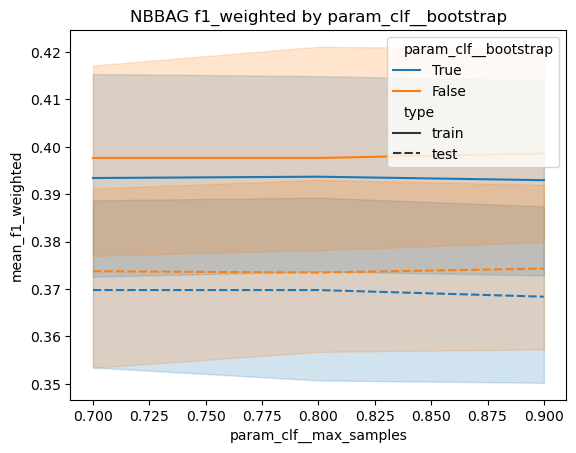

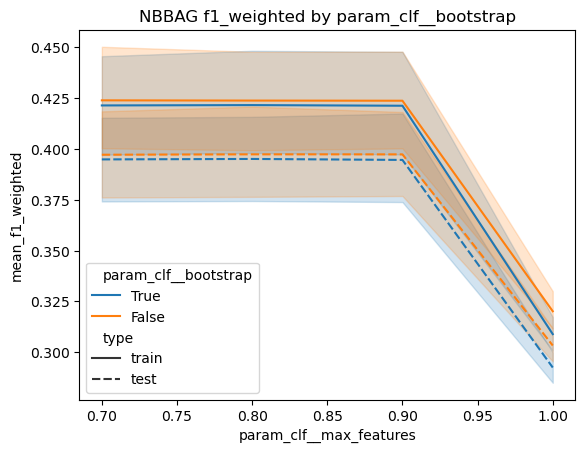

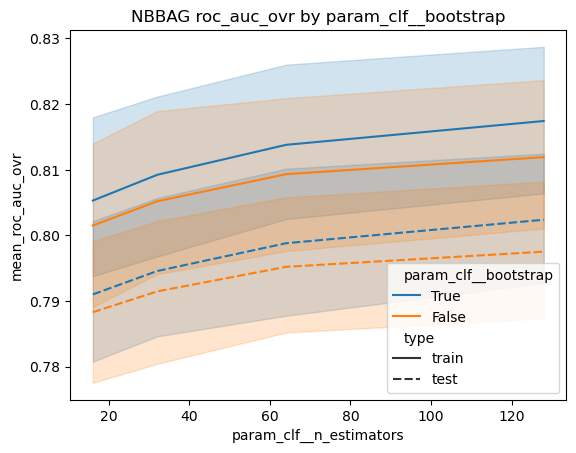

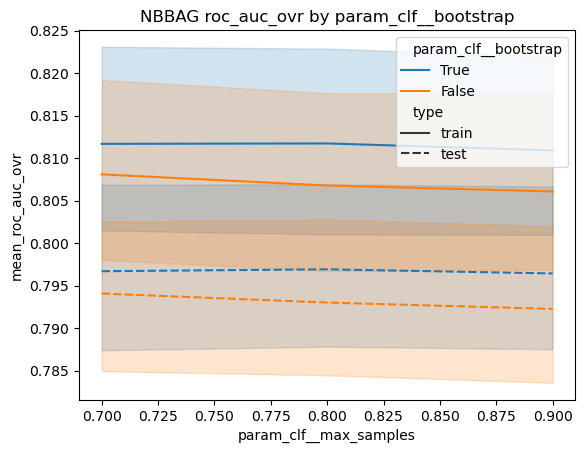

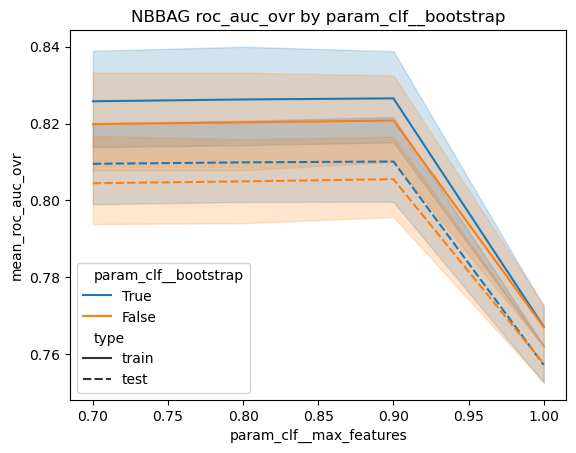

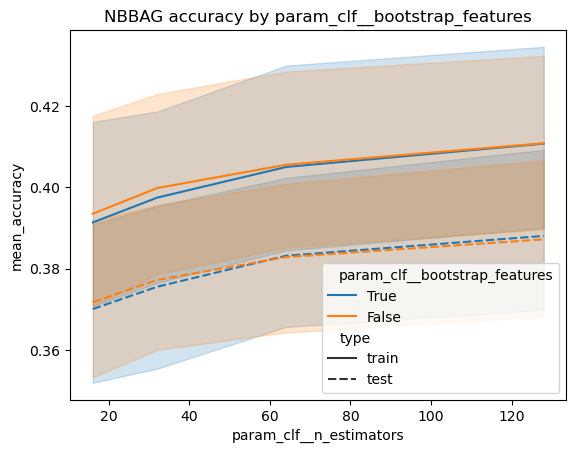

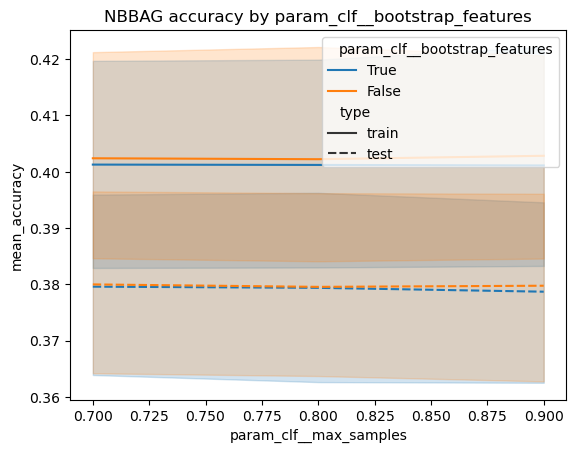

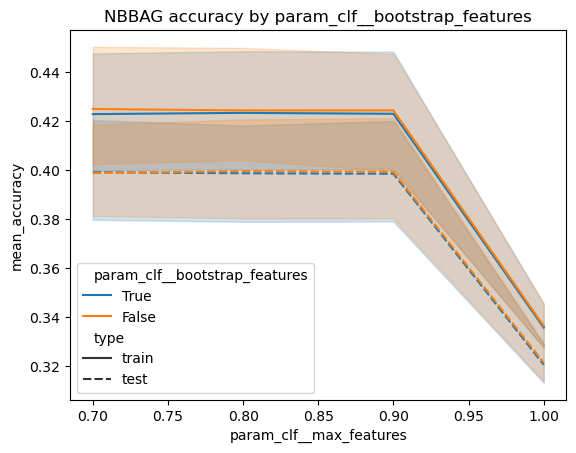

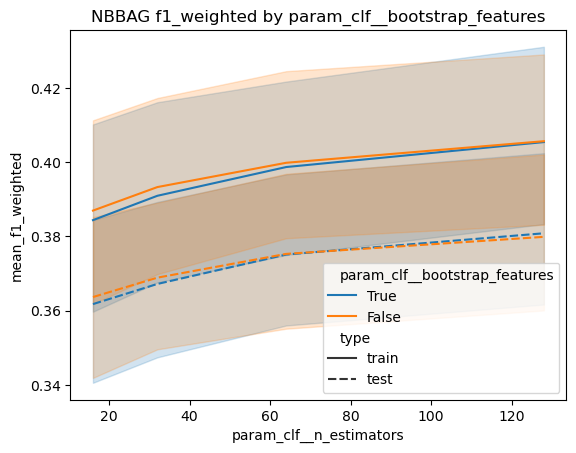

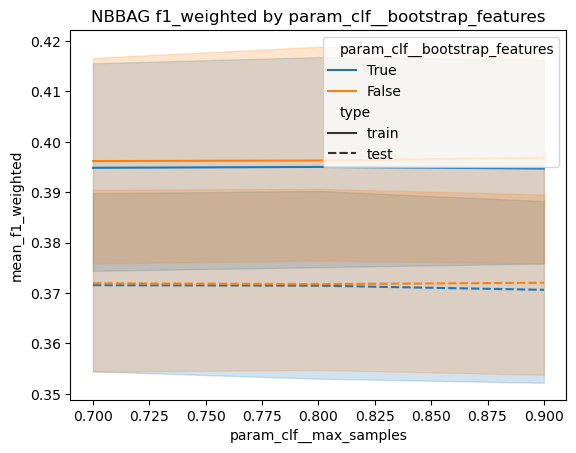

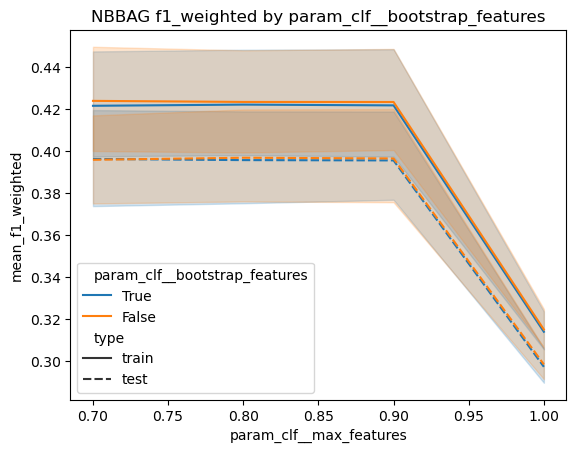

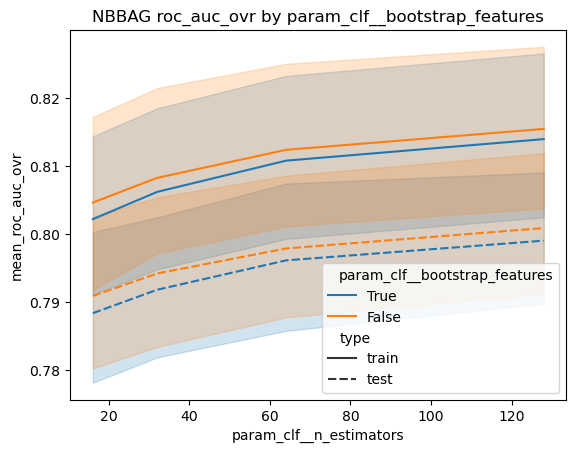

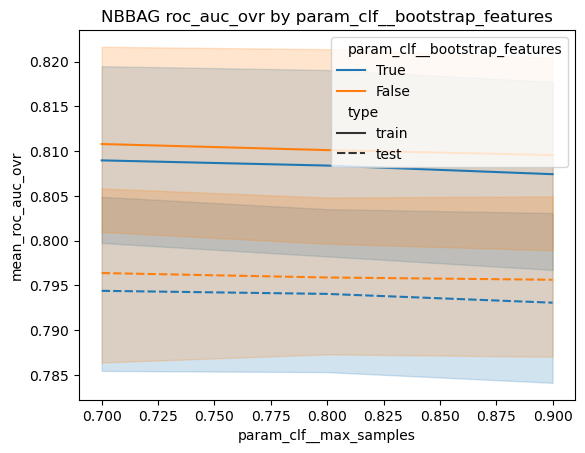

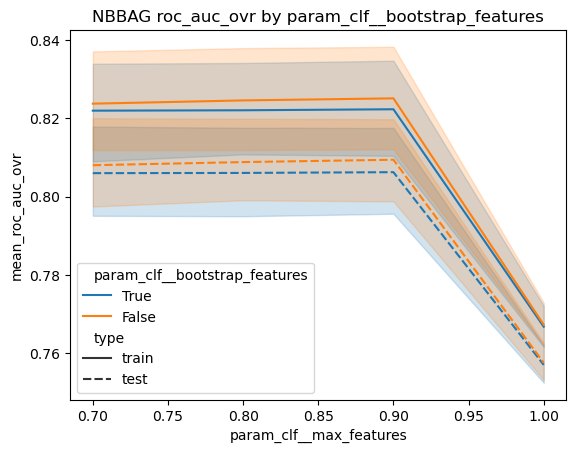

results/NBbag


/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__learning_rate', 'param_clf__n_estimators',
       'params'],
      dtype='object')


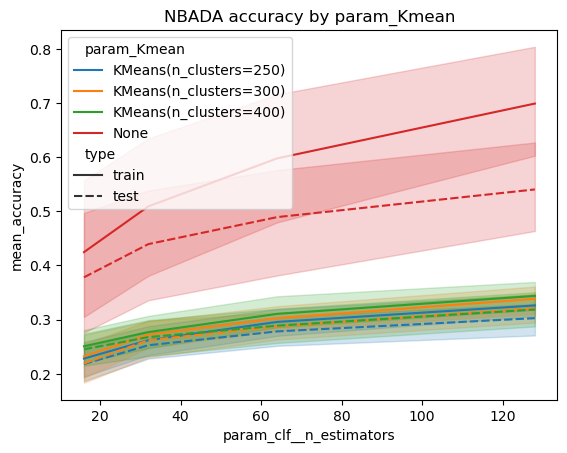

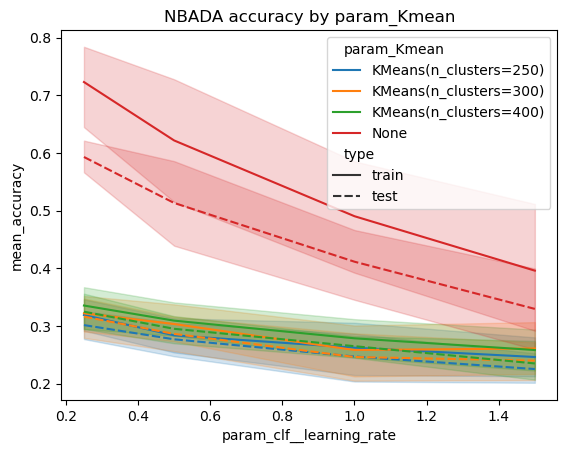

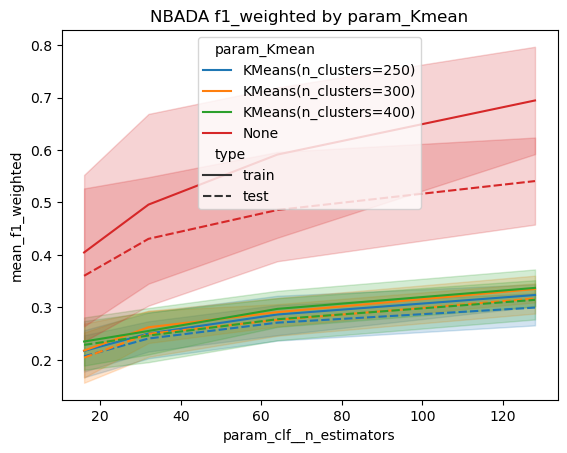

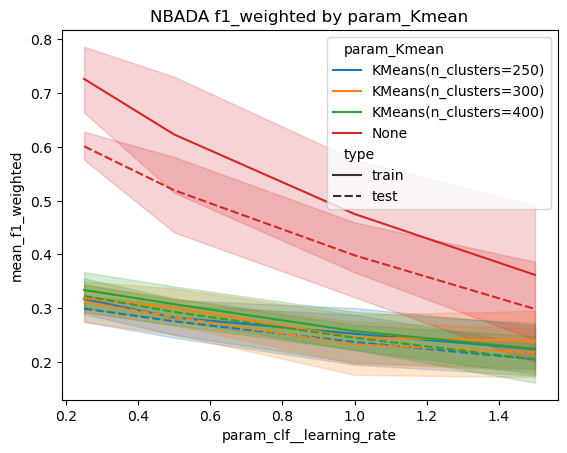

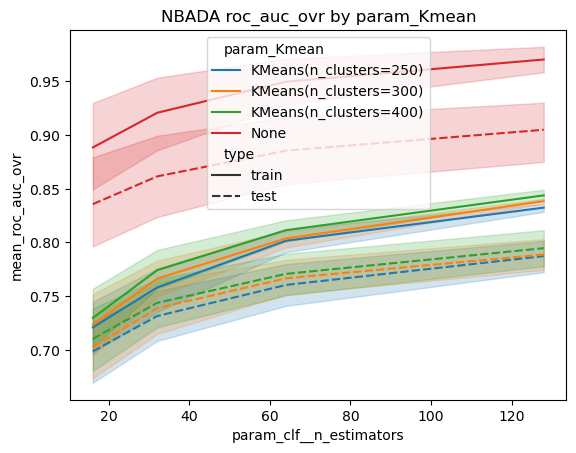

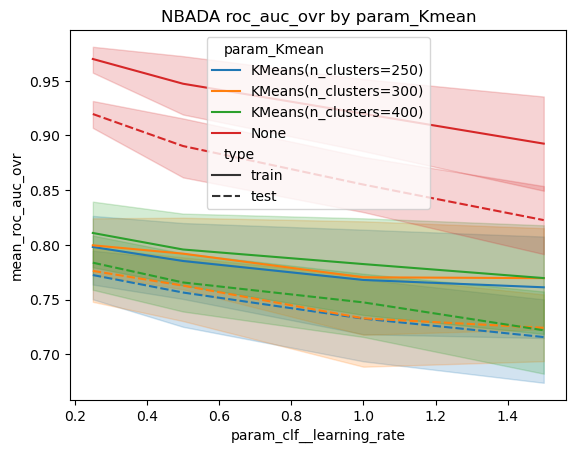

results/NBada


/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__learning_rate', 'param_clf__n_estimators',
       'params'],
      dtype='object')


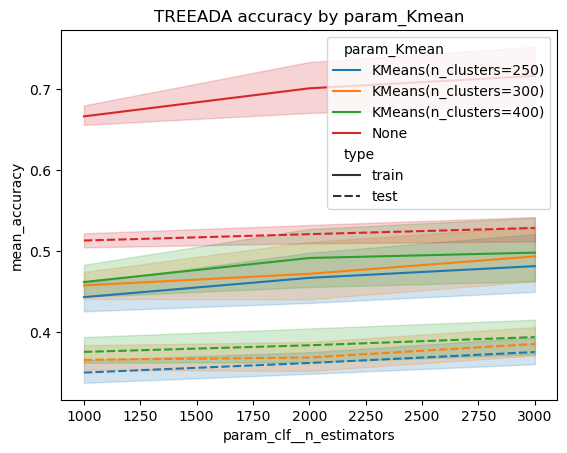

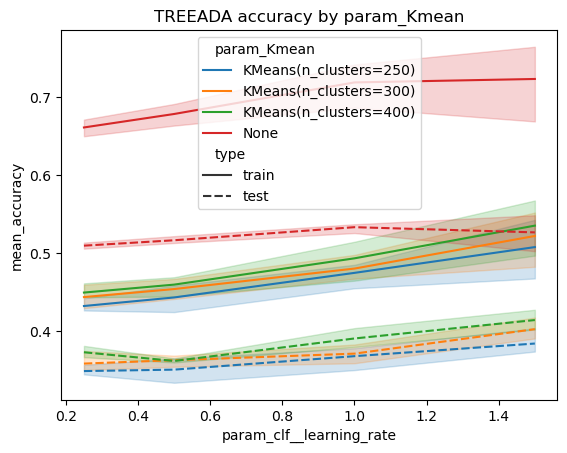

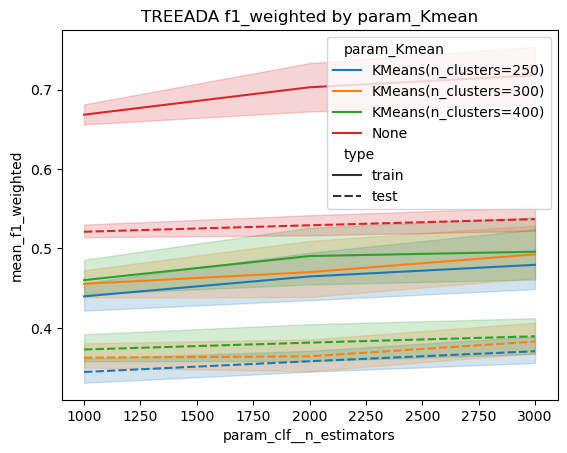

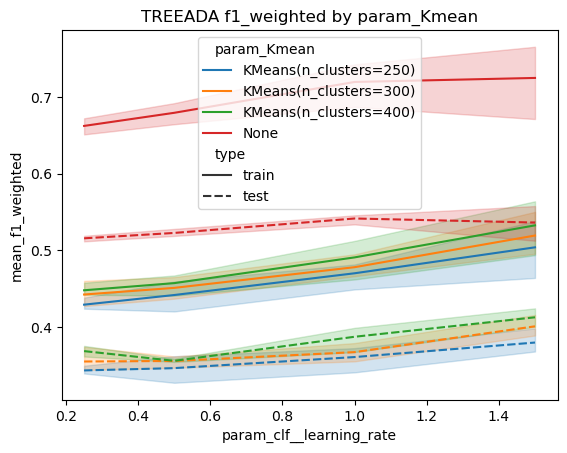

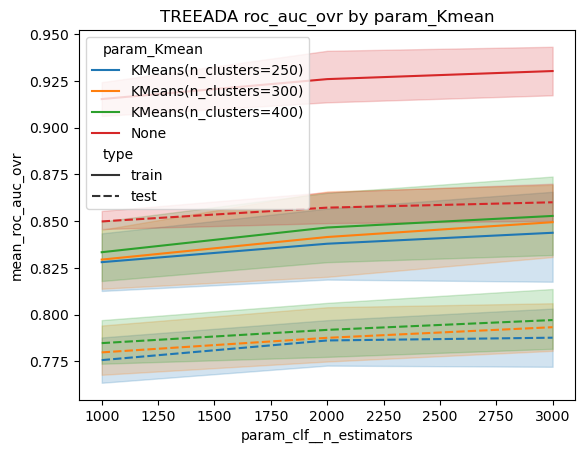

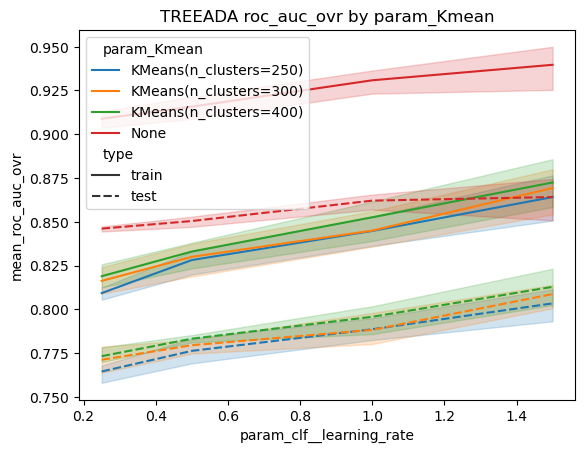

results/treeada


/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9472/4229385141.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [18]:
#keys = ['nb','mlp','svm','rf']
#xs = ['param_Kmean',['param_clf__learning_rate_init','param_clf__alpha','param_Kmean'],['param_clf__gamma','param_Kmean','param_clf__C'],['param_clf__n_estimators','param_Kmean','param_clf__max_depth']]
keys = ['SVMbag','stack','mlpbag','NBbag','NBada','treeada']
xs = [['param_clf__max_samples','param_clf__max_features'],['param_final_estimator'],['param_Kmean'],['param_clf__n_estimators', 'param_clf__max_samples','param_clf__max_features'],['param_clf__n_estimators','param_clf__learning_rate'],['param_clf__n_estimators','param_clf__learning_rate'],'final_estimator']
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, x_test, y_test, save=save, out_dir=res_dir,loc=agg_out_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir)

In [21]:
model = load_model('stack',agg_out_dir)
df = pd.DataFrame.from_dict(model.cv_results_)
best_model = model.best_estimator_

In [47]:
best_model

StackingClassifier(cv=4,
                   estimators=[('Kmean_mlp',
                                Pipeline(steps=[('Kmean',
                                                 KMeans(n_clusters=400)),
                                                ('pca', PCA(n_components=0.99)),
                                                ('scaler', MinMaxScaler()),
                                                ('clf',
                                                 MLPClassifier(alpha=0.4,
                                                               hidden_layer_sizes=[256,
                                                                                   128,
                                                                                   64,
                                                                                   64],
                                                               learning_rate_init=0.004))])),
                               ('Kmean_svm',
                                Pipeline(steps=[('Kmean',
                                                 KMeans(n_clusters=400)),
                                                ('pca', PCA(n_components=0.99)),
                                                ('scal...
                                Pipeline(steps=[('Kmean',
                                                 KMeans(n_clusters=400)),
                                                ('pca', PCA(n_components=0.99)),
                                                ('scaler', MinMaxScaler()),
                                                ('clf',
                                                 RandomForestClassifier(max_depth=100,
                                                                        n_estimators=450))])),
                               ('plain_svm',
                                Pipeline(steps=[('pca', PCA(n_components=0.99)),
                                                ('scaler', MinMaxScaler()),
                                                ('clf',
                                                 SVC(C=1.25,
                                                     gamma=0.12857142857142856,
                                                     probability=True))]))],
                   final_estimator=LogisticRegression())

In [49]:
best_model.named_estimators['Kmean_rf'].named_steps['clf']

RandomForestClassifier(max_depth=100, n_estimators=450)

In [28]:
df['name'] = [np.array(i)[:,0]for i in df['param_estimators']]


/tmp/ipykernel_9472/1094648329.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [33]:
df.sort_values('rank_test_roc_auc_ovr')[['param_final_estimator','name','mean_test_accuracy','rank_test_accuracy','mean_test_f1_weighted','rank_test_f1_weighted','mean_test_roc_auc_ovr','rank_test_roc_auc_ovr']]

param_final_estimator  \
2       LogisticRegression()   
12      LogisticRegression()   
16      LogisticRegression()   
30      LogisticRegression()   
18      LogisticRegression()   
6       LogisticRegression()   
10      LogisticRegression()   
24      LogisticRegression()   
28      LogisticRegression()   
20      LogisticRegression()   
26      LogisticRegression()   
17  CalibratedClassifierCV()   
31  CalibratedClassifierCV()   
25  CalibratedClassifierCV()   
3   CalibratedClassifierCV()   
19  CalibratedClassifierCV()   
7   CalibratedClassifierCV()   
11  CalibratedClassifierCV()   
13  CalibratedClassifierCV()   
21  CalibratedClassifierCV()   
34      LogisticRegression()   
29  CalibratedClassifierCV()   
27  CalibratedClassifierCV()   
35  CalibratedClassifierCV()   
5   CalibratedClassifierCV()   
14      LogisticRegression()   
0       LogisticRegression()   
4       LogisticRegression()   
33  CalibratedClassifierCV()   
32      LogisticRegression()   
15  CalibratedClassifierCV()   
22      LogisticRegression()   
8       LogisticRegression()   
9   CalibratedClassifierCV()   
23  CalibratedClassifierCV()   
1   CalibratedClassifierCV()   

                                                 name  mean_test_accuracy  \
2         [Kmean_mlp, Kmean_svm, Kmean_rf, plain_svm]             0.79000   
12        [Kmean_mlp, Kmean_rf, plain_mlp, plain_svm]             0.78900   
16         [Kmean_mlp, Kmean_rf, plain_svm, plain_rf]             0.78350   
30  [Kmean_mlp, Kmean_svm, Kmean_rf, plain_mlp, pl...             0.78675   
18        [Kmean_mlp, plain_mlp, plain_svm, plain_rf]             0.78325   
6        [Kmean_mlp, Kmean_svm, plain_mlp, plain_svm]             0.78550   
10        [Kmean_mlp, Kmean_svm, plain_svm, plain_rf]             0.78675   
24         [Kmean_svm, Kmean_rf, plain_svm, plain_rf]             0.78800   
28         [Kmean_rf, plain_mlp, plain_svm, plain_rf]             0.78675   
20        [Kmean_svm, Kmean_rf, plain_mlp, plain_svm]             0.78450   
26        [Kmean_svm, plain_mlp, plain_svm, plain_rf]             0.78625   
17         [Kmean_mlp, Kmean_rf, plain_svm, plain_rf]             0.79025   
31  [Kmean_mlp, Kmean_svm, Kmean_rf, plain_mlp, pl...             0.78825   
25         [Kmean_svm, Kmean_rf, plain_svm, plain_rf]             0.78650   
3         [Kmean_mlp, Kmean_svm, Kmean_rf, plain_svm]             0.78950   
19        [Kmean_mlp, plain_mlp, plain_svm, plain_rf]             0.79150   
7        [Kmean_mlp, Kmean_svm, plain_mlp, plain_svm]             0.78600   
11        [Kmean_mlp, Kmean_svm, plain_svm, plain_rf]             0.79000   
13        [Kmean_mlp, Kmean_rf, plain_mlp, plain_svm]             0.79100   
21        [Kmean_svm, Kmean_rf, plain_mlp, plain_svm]             0.78850   
34                   [plain_mlp, plain_svm, plain_rf]             0.78400   
29         [Kmean_rf, plain_mlp, plain_svm, plain_rf]             0.78750   
27        [Kmean_svm, plain_mlp, plain_svm, plain_rf]             0.78700   
35                   [plain_mlp, plain_svm, plain_rf]             0.78300   
5          [Kmean_mlp, Kmean_svm, Kmean_rf, plain_rf]             0.70550   
14         [Kmean_mlp, Kmean_rf, plain_mlp, plain_rf]             0.69350   
0         [Kmean_mlp, Kmean_svm, Kmean_rf, plain_mlp]             0.69375   
4          [Kmean_mlp, Kmean_svm, Kmean_rf, plain_rf]             0.68875   
33                   [Kmean_mlp, Kmean_svm, Kmean_rf]             0.70175   
32                   [Kmean_mlp, Kmean_svm, Kmean_rf]             0.69950   
15         [Kmean_mlp, Kmean_rf, plain_mlp, plain_rf]             0.70325   
22         [Kmean_svm, Kmean_rf, plain_mlp, plain_rf]             0.68450   
8         [Kmean_mlp, Kmean_svm, plain_mlp, plain_rf]             0.69200   
9         [Kmean_mlp, Kmean_svm, plain_mlp, plain_rf]             0.70275   
23         [Kmean_svm, Kmean_rf, plain_mlp, plain_rf]             0.69275   
1         [Kmean_mlp, Kmean_svm, Kmean_rf, plain_m

In [37]:
interesting_stacked = df.iloc[[2,13,19,30,32,34]][['param_final_estimator','name','mean_test_accuracy','rank_test_accuracy','mean_test_f1_weighted','rank_test_f1_weighted','mean_test_roc_auc_ovr','rank_test_roc_auc_ovr']]

In [38]:
interesting_stacked.to_csv(Path(res_dir,'interesting_stack.csv'),index=False)
interesting_stacked.to_latex(Path(res_dir,'interesting_stack.tex'),index=False)

/tmp/ipykernel_9472/4031898664.py:2: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



/tmp/ipykernel_9472/197124157.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<AxesSubplot: xlabel='param_final_estimator'>

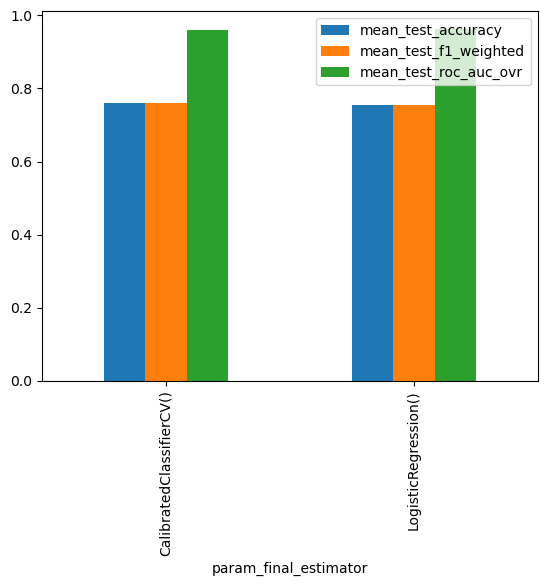

In [44]:
df.astype({'param_final_estimator':str}).groupby('param_final_estimator').mean().plot.bar(y=[f'mean_test_{i}' for i in ['accuracy','f1_weighted','roc_auc_ovr']])

In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

In [ ]:
if cluster_anl:
    clusters =np.arange(1,521)
    kmean_values = np.array([KMeans(n_clusters=k, random_state=STATE).fit_predict(features.values) for k in tqdm(clusters)])
    df = pd.DataFrame(data=kmean_values.T,columns=np.arange(kmean_values.shape[0])+1)
    df.to_csv('kmeans_save.csv',index=False)
    purities = [purity_score(metadata['class'],row) for row in kmean_values]
    fig = plot(clusters,purities)
    # axvline(x=optimal_k,color='r',ls='--',label='Elbow Point')
    xlabel('Number of Clusters')
    ylabel('Gross Purity Metric')
    title('Gross Cluster Purity vs. Clusters')
    tight_layout()
    #legend()
    if save:
        savefig(Path(res_dir,'Cluster_Choice_Gross_Purity_larger.png'))
    show() 

In [ ]:
#temp = analyze('nb','param_pca__n_components', x_test, y_test, save=save, out_dir=res_dir)

In [ ]:
# df = pd.DataFrame(columns = ['nb','mlp','svm','rf'])
# le = LabelEncoder()
# le.fit(y_test)
# for item in df.columns:
#     best_model = load_model(item).best_estimator_
#     df[item] = le.transform(best_model.predict(x_test))

In [ ]:
# df.corr()

In [ ]:
# stack = load_model('stack',loc=agg_out_dir)
# df = pd.DataFrame.from_dict(stack.cv_results_)